In [46]:
import os 
import csv
import pandas as pd
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [47]:
import matplotlib.pyplot as plt
def myplot(df):
    title = ''
    if isinstance(df, pd.DataFrame):
        df = np.array(df)
        title = df.columns[0]
    plt.plot(df)
    plt.title(title)
    plt.show()

In [48]:
def get_from_short_df_data(df, windows_length):
    split = 0.2
    maxindex = df.idxmax(axis = 0)
    begin = int(maxindex - windows_length * split)
    end = int(maxindex + windows_length * (1 - split))
    return df[begin:end].reset_index(drop=True)

In [49]:
def get_from_long_df_data(df, windows_length):
    time = len(df)/2000
    df_list = []
    if time < 10:
        seq = 2
    elif time < 25:
        seq = 7
    elif time < 35:
        seq = 10
    else:
        seq = 20
    for i in range(seq):
        begin = int(len(df) // (seq+1) *(i+1))
        end = int(begin + windows_length)
        df_list.append(df[begin:end].reset_index(drop=True))
    df = pd.concat(df_list, axis = 1)
    return df

In [50]:
#def get_from_light_df_data(df):
    

In [51]:
def get_from_raw_data(datapath, dr):
    short_data_list = ['CloseOutDoor', 'CloseKitchenDoor','CloseToiletDoor']
    long_data_list = ['WashHand','Bathe','FlushToilet','MicrowaveOven','BoilWater','InductionCooker','NoAppliance']
    light_data_list = ['KitchenLight']
    
    windows_length = 0.5 * 2000
    files = os.listdir(datapath + '\\' + dr)
    label = dr
    df_list = []
    for file in files:
        #print(datapath + '\\' + dr + '\\' +file)
        #file_name = datapath + '\\' + dr + '\\' +file    
        df = pd.read_csv(datapath + '\\' + dr + '\\' +file, header = 0,  usecols = ['mean_raw_ADC'])
        df.rename(columns = {'mean_raw_ADC':label}, inplace = True)
        df = df - df.mean(axis = 0) 
        if dr in short_data_list:
            df = get_from_short_df_data(df, windows_length)
        elif dr in long_data_list:
            df = get_from_long_df_data(df, windows_length)
        #elif dr in light_data_list:
        #    df = get_from_light_df_data(df, windows_length)
        else:
            raise RuntimeError('event out of range')
        df_list.append(df)
    df_label = pd.concat(df_list, axis = 1)
    return df_label

In [52]:
def extract_feature(df_label, num_label):
    lable = pd.Series(df_label.columns.values)
    #mad = df_label.mad(axis=0).reset_index(drop=True)
    std = df_label.std(axis=0).reset_index(drop=True)
    skew = df_label.skew(axis=0).reset_index(drop=True)
    kurt = df_label.kurt(axis=0).reset_index(drop=True)
    #max_ = df_label.max(axis=0).reset_index(drop=True)
    #df_feature = pd.DataFrame([ mad, std, skew, kurt, max_,lable]).T
    df_feature = pd.DataFrame([ std, skew, kurt, lable]).T
    #df_feature.columns = [ 'mad', 'std', 'skew', 'kurt', 'max_', 'label']
    df_feature.columns = [  'std', 'skew', 'kurt',  'label']
    df_feature["num_label"] = num_label
    return df_feature

In [53]:
datapath = r'.\data3-29'
if not os.path.exists(datapath):
    raise RuntimeError('dir not exist')
feature_list = []
event_list = []
dirs = os.listdir(datapath)
num_label = 1
for dr in dirs:
    if not os.path.isdir(datapath + '\\' + dr) :
            continue
    print(dr+' ready')
    df_label = get_from_raw_data(datapath, dr)
    event_list.append(df_label)
    #print(dr + 'is as follows')
    #print(df_label.head())
    
    #先不做归一化
    feature = extract_feature(df_label ,num_label)
    feature_list.append(feature)
    num_label += 1
    print(dr+' completed')
event_all = pd.concat(event_list, axis = 1)
feature_all = pd.concat(feature_list, axis = 0).reset_index(drop=True)

Bathe ready
Bathe completed
BoilWater ready
BoilWater completed
CloseKitchenDoor ready
CloseKitchenDoor completed
CloseOutDoor ready
CloseOutDoor completed
CloseToiletDoor ready
CloseToiletDoor completed
FlushToilet ready
FlushToilet completed
InductionCooker ready
InductionCooker completed
MicrowaveOven ready
MicrowaveOven completed
NoAppliance ready
NoAppliance completed
WashHand ready
WashHand completed


In [54]:
#for event in event_list:
#    for index, row in event.iteritems():
#        myplot(row)

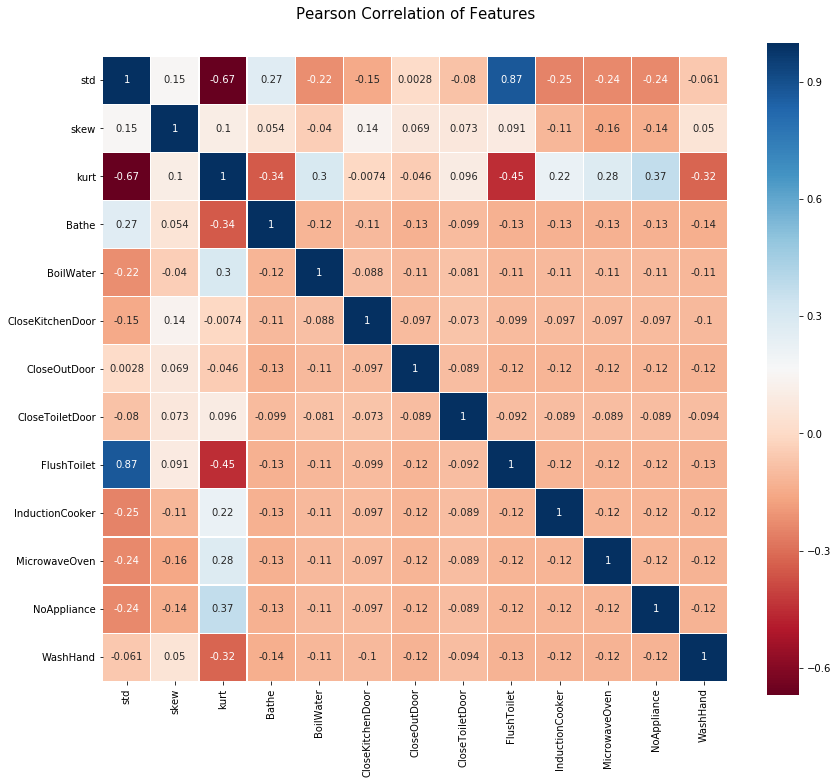

In [55]:
import seaborn as sns

def nomalized(X):
    X_std = (X-X.min(axis = 0))/(X.max(axis = 0) - X.min(axis = 0))
    return X_std
#one-hot
feature_all_dummy = feature_all.join(pd.get_dummies(feature_all.label))
feature_all_dummy.drop(['label'],axis=1,inplace=True)
feature_all_dummy.drop(['num_label'],axis=1,inplace=True)

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(feature_all_dummy.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [56]:
feature_all_no_label = feature_all.drop(['label'],axis=1)
feature_all_no_label.dropna(axis=0,how='any',inplace = True)
feature_all_no_label = nomalized(feature_all_no_label[["std","skew","kurt"]]).join(feature_all_no_label["num_label"])
Xandy = feature_all_no_label.values.astype(np.float32)
X = Xandy[:,:-1]
X = nomalized(X)
y = Xandy[:,-1]
from sklearn.metrics import accuracy_score
import xgboost
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth = 5)
clf.fit(X, y)
y_pred = clf.predict(X)
accuracy = accuracy_score(y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.13%


# 3-classification
- CloseOutDoor
- FlushToilet
- WashHand

In [57]:
feature_all.head()

,std,skew,kurt,label,num_label
0,417.01,-0.108784,-0.00343565,Bathe,1
1,419.814,0.030572,-0.286475,Bathe,1
2,391.155,-0.0663939,0.0845249,Bathe,1
3,424.976,0.0220033,-0.320261,Bathe,1
4,515.602,0.027497,-0.156131,Bathe,1


In [58]:
def split_data(df, p = 0.75):
    point = int(len(df) * p)
    return (df[:point],df[point:])
    
feature_CloseOutDoor = feature_all[feature_all.label == "CloseOutDoor"]
feature_CloseOutDoor["num_label"] = 1
feature_CloseOutDoor_train, feature_CloseOutDoor_test =  split_data(feature_CloseOutDoor)

feature_FlushToilet = feature_all[feature_all.label == "FlushToilet"]
feature_FlushToilet["num_label"] = 2
feature_FlushToilet_train, feature_FlushToilet_test =  split_data(feature_FlushToilet)

feature_WashHand = feature_all[feature_all.label == "WashHand"]
feature_WashHand["num_label"] = 3
feature_WashHand_train, feature_WashHand_test =  split_data(feature_WashHand)

feature_train = pd.concat([feature_CloseOutDoor_train,feature_FlushToilet_train,feature_WashHand_train], axis = 0).reset_index(drop=True)
feature_test = pd.concat([feature_CloseOutDoor_test,feature_FlushToilet_test,feature_WashHand_test], axis = 0).reset_index(drop=True)
feature_train.drop(['label'],axis=1,inplace=True)
feature_test.drop(['label'],axis=1,inplace=True)
feature_train_arr = feature_train.values.astype(np.float32)
feature_test_arr = feature_test.values.astype(np.float32)

X_train = feature_train_arr[:,:-1]
y_train = feature_train_arr[:,-1]
X_test = feature_test_arr[:,:-1]
y_test = feature_test_arr[:,-1]
print(X_train.shape, y_train.shape,X_test.shape,y_test.shape)

(46, 3) (46,) (17, 3) (17,)


In [59]:
feature_test_arr

array([[ 2.94e+02, -1.69e-03,  1.70e+00,  1.00e+00],
       [ 1.58e+02,  3.01e-02,  9.44e-01,  1.00e+00],
       [ 2.93e+02,  3.53e-03,  2.32e+00,  1.00e+00],
       [ 3.23e+02, -1.48e-03,  2.69e+00,  1.00e+00],
       [ 2.28e+02,  4.04e-02,  1.79e+00,  1.00e+00],
       [ 8.72e+02,  1.29e-02, -9.25e-01,  2.00e+00],
       [ 1.06e+03,  2.84e-02, -1.34e+00,  2.00e+00],
       [ 9.83e+02,  4.11e-02, -1.20e+00,  2.00e+00],
       [ 1.03e+03,  9.13e-03, -1.28e+00,  2.00e+00],
       [ 9.16e+02,  2.55e-02, -1.16e+00,  2.00e+00],
       [ 1.12e+03,  2.31e-02, -1.43e+00,  2.00e+00],
       [ 2.03e+02, -3.97e-02, -3.06e-01,  3.00e+00],
       [ 2.14e+02,  5.60e-02,  7.23e-01,  3.00e+00],
       [ 1.66e+02,  2.02e-02,  2.52e-01,  3.00e+00],
       [ 2.21e+02, -1.07e-02, -4.99e-01,  3.00e+00],
       [ 1.91e+02,  5.05e-02, -7.69e-02,  3.00e+00],
       [ 1.85e+02,  1.39e-02, -5.27e-01,  3.00e+00]], dtype=float32)

Accuracy: 88.24
Confusion matrix, without normalization
[[3 0 2]
 [0 6 0]
 [0 0 6]]
Normalized confusion matrix
[[0.6 0.  0.4]
 [0.  1.  0. ]
 [0.  0.  1. ]]


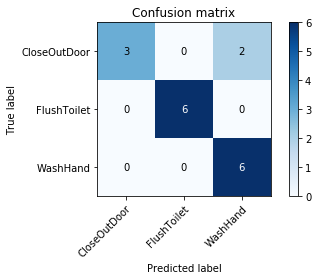

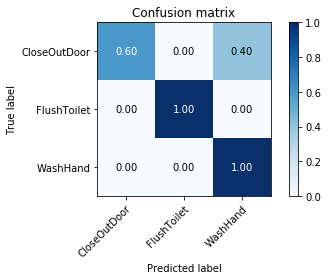

Confusion matrix, without normalization
[[3 0 2]
 [0 6 0]
 [0 0 6]]
Normalized confusion matrix
[[0.6 0.  0.4]
 [0.  1.  0. ]
 [0.  0.  1. ]]


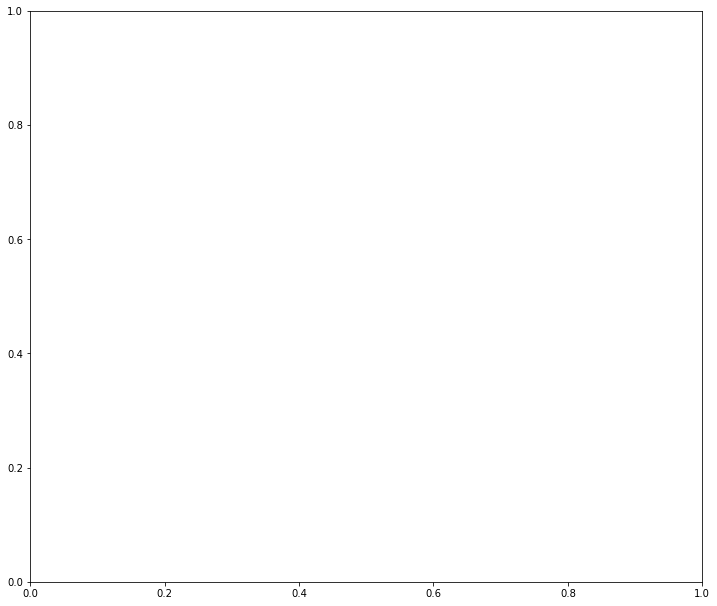

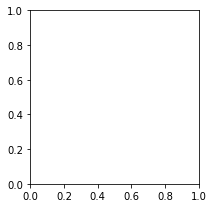

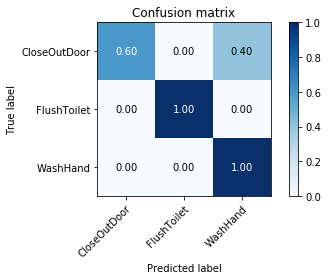

In [70]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize: 
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        cm = cm
        print('Confusion matrix, without normalization')
    print(cm)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#####
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy: %.2f" % (accuracy * 100.0))
class_names = ["CloseOutDoor","FlushToilet","WashHand"]

#设置输出的数据精度为2位小数
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_test_pred, classes=class_names, normalize=True)

plt.show()

def plot_two_confusion_matrix(y_test, y_test_pred, class_names):
    f1 = plt.figure(1)
    f1.set_size_inches(26.5, 10.5)

    plt.subplot(121)
    # Plot normalized confusion matrix
    # plt.figure(figsize=(10,10))
    #plot_confusion_matrix(cm, classes, normalize=True)
    plot_confusion_matrix(y_test, y_test_pred, class_names)
    
    plt.subplot(122)
    # Plot non-normalized confusion matrix
    # plt.figure(figsize=(10,10))
    #plot_confusion_matrix(cm, classes)
    plot_confusion_matrix(y_test, y_test_pred, class_names, normalize=True)
plot_two_confusion_matrix(y_test, y_test_pred, class_names)

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def model_and_plot(model ,X_train, y_train, X_test, y_test):
    clf = model()
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print("Accuracy: %.2f" % (accuracy * 100.0))
    cm = confusion_matrix(y_test,y_test_pred)
    #print(cm)
    plot_two_confusion_matrix(cm, classes = ["CloseOutDoor","FlushToilet","WashHand"])


Accuracy: 88.24
Normalized confusion matrix
Confusion matrix, without normalization


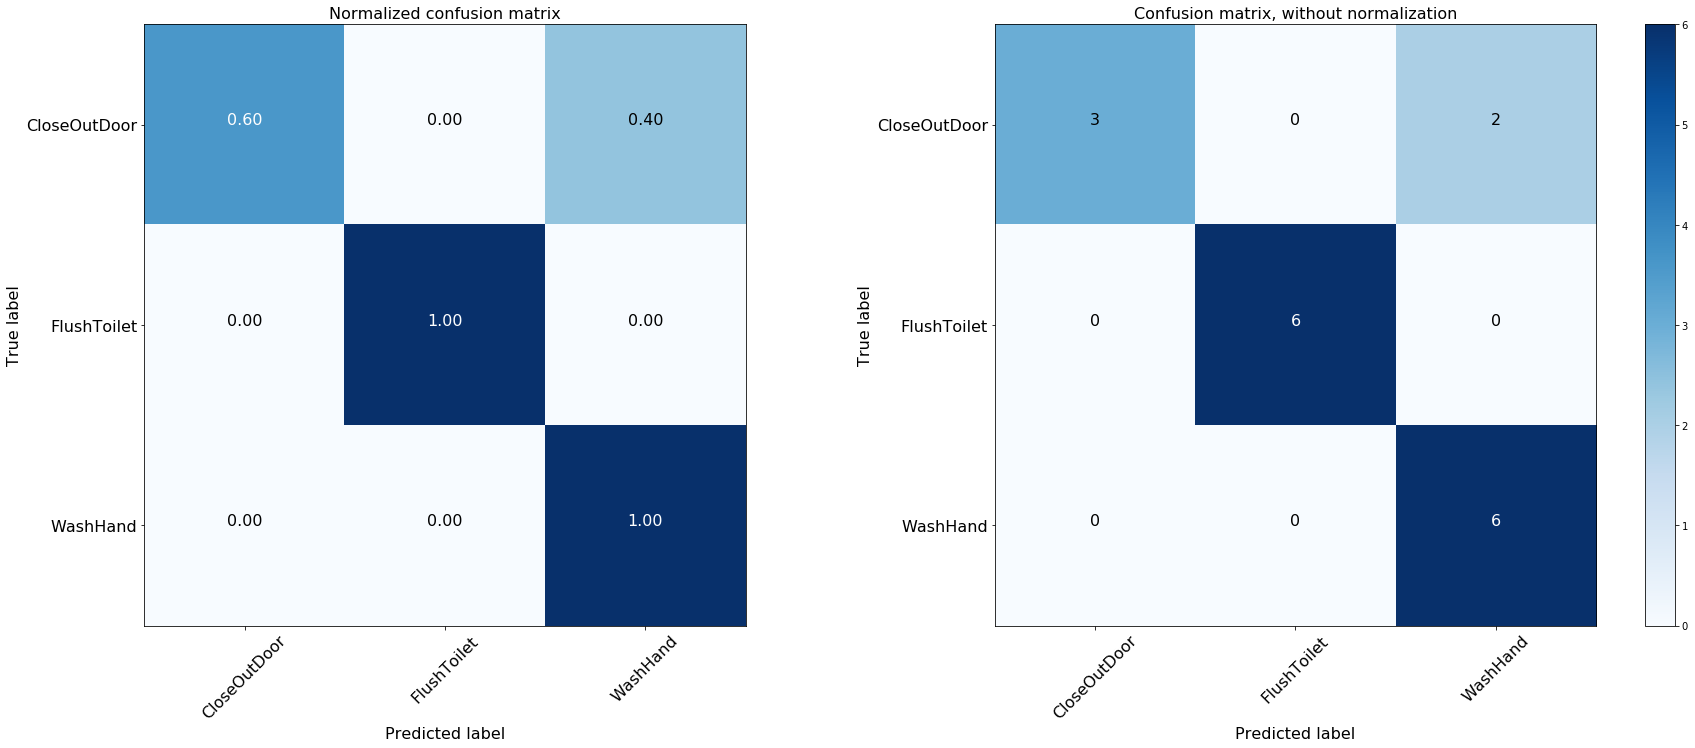

In [22]:
model_and_plot(KNeighborsClassifier, X_train, y_train, X_test, y_test)

Accuracy: 64.71
Normalized confusion matrix
Confusion matrix, without normalization


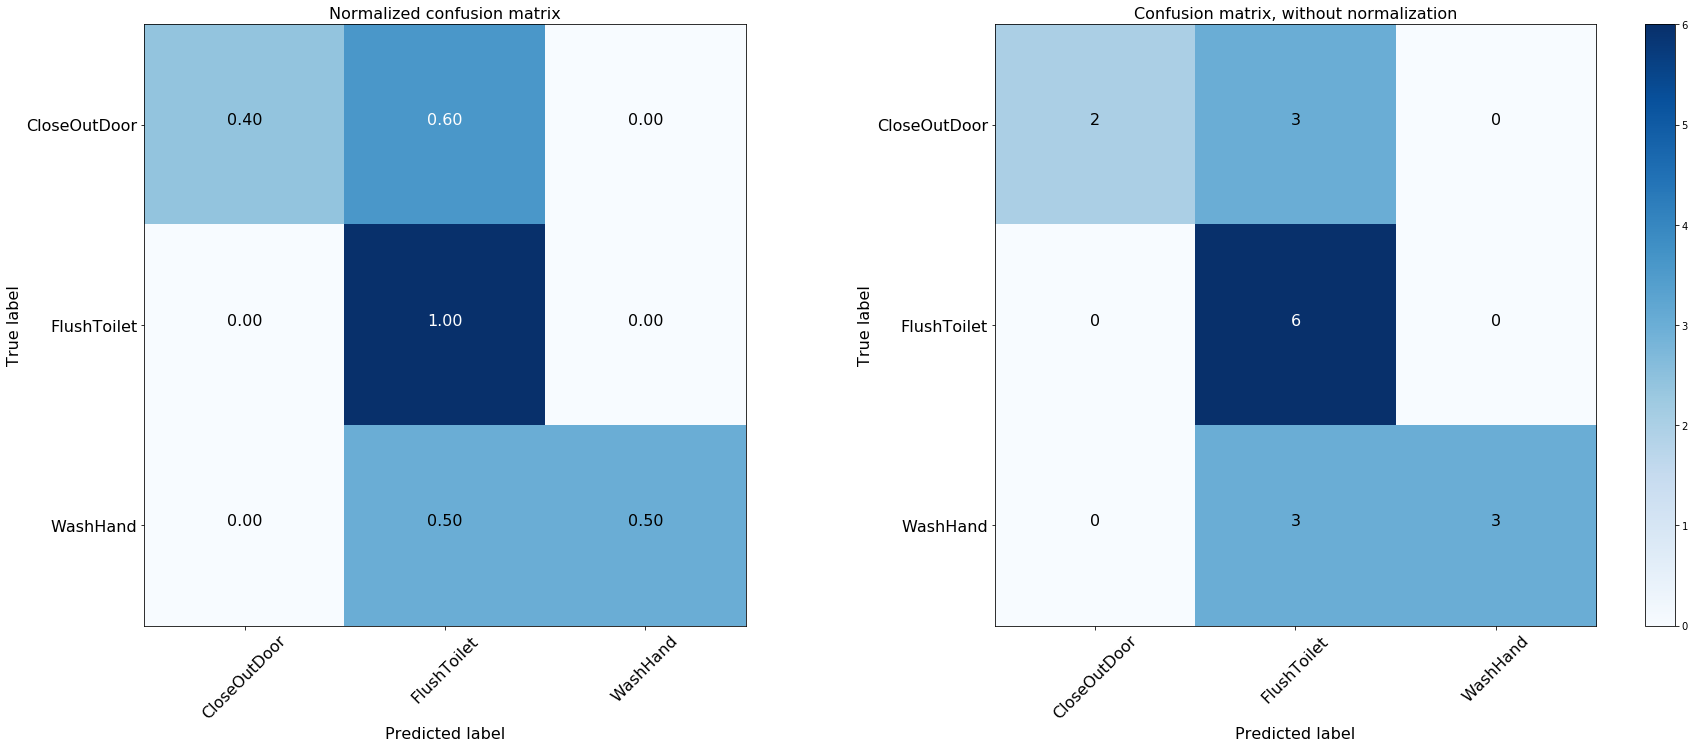

In [23]:
model_and_plot(SVC, X_train, y_train, X_test, y_test)


Accuracy: 88.24
Normalized confusion matrix
Confusion matrix, without normalization


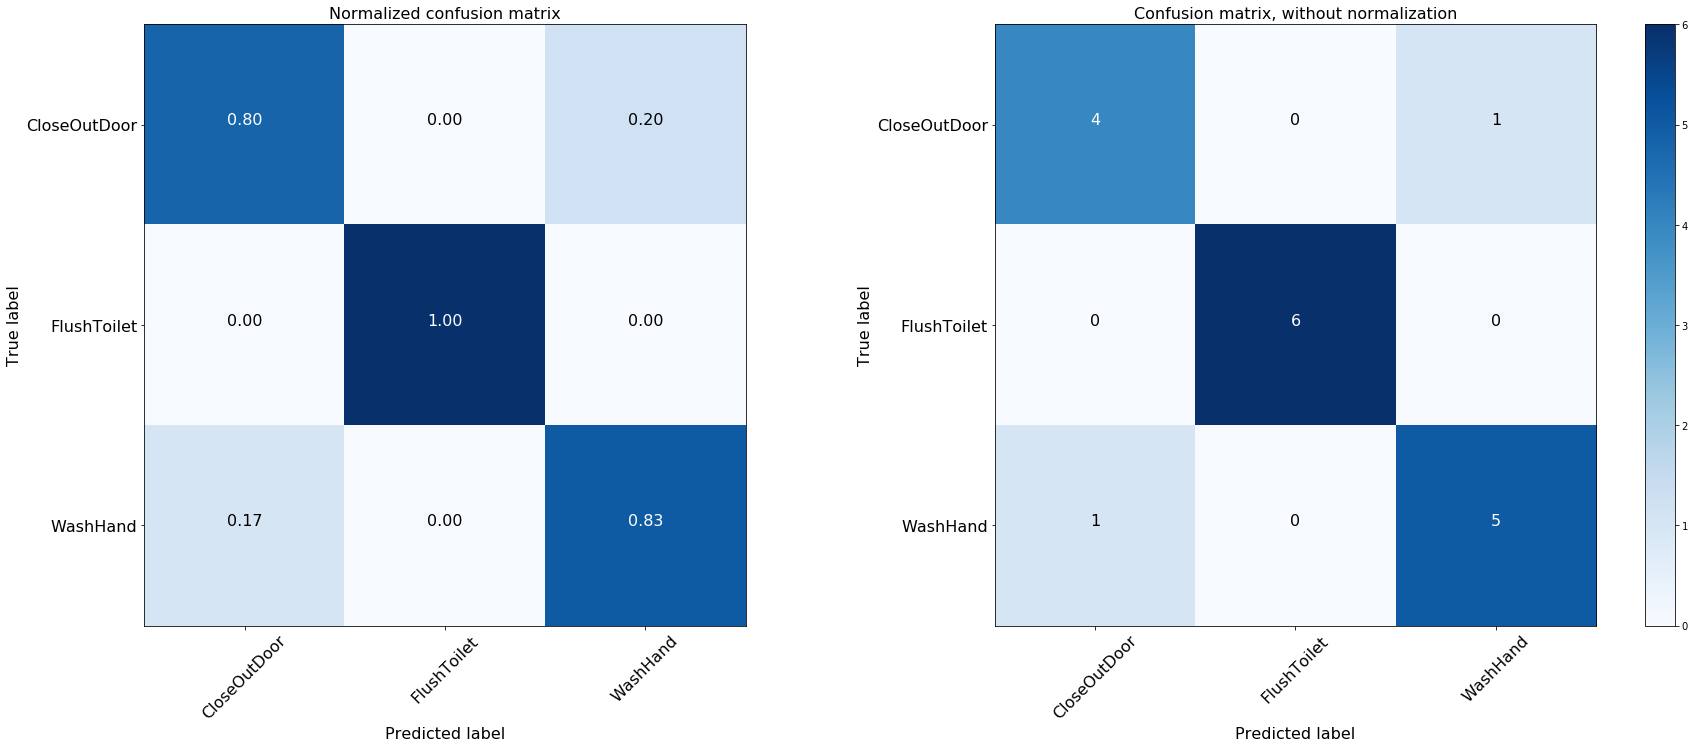

In [27]:
model_and_plot(RandomForestClassifier, X_train, y_train, X_test, y_test)


In [30]:
    from sklearn.ensemble import RandomForestClassifier
    X = [[1,2,3],[4,5,6]]
    y = ['a','b']
    clf = RandomForestClassifier()
    clf.fit(X, y)
    y_test_pred = clf.predict(X)

In [31]:
y_test_pred

array(['a', 'b'], dtype='<U1')

In [44]:
from sklearn import svm, datasets
clf = svm()
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

TypeError: 'module' object is not callable

In [39]:
iris

{'DESCR': '.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ===========

In [78]:
!git clone git@github.com:ChengWang95/learngit.git

Cloning into 'learngit'...


In [75]:
!cd D:\CODE 

In [76]:
!cd

D:\CODE\Geophone
